# Introduction

Hi there! This notebook will be presenting a small walkthrough in extracting the metadata of publications from the HathiTrust Digital Library as well as illustrating geographic data in Python. As an exercise, we will be examining and illustrating the publication locations of a collection of Dadaist literature extracted from HathiTrust.

[Dada](https://en.wikipedia.org/wiki/Dada), an art and literature movement which stemmed as a reaction to the physical and psychological trauma wrought by World War I, a conflict unmatched at the time in its scale, death toll, and devastation.

Below is a painting by [Max Ernst](https://en.wikipedia.org/wiki/Max_Ernst), a prominent German Dada artist.
<img src="ernst.jpg">

# Background

The [HathiTrust Digital Library](https://www.hathitrust.org/) contains over 14 million volumes scanned from academic libraries around the world (primarily in North America). The [HathiTrust Research Center](https://analytics.hathitrust.org/) allows researchers to access almost all of those texts in a few different modes for computational text analysis. 

For more information on HTRC: 
* [Library text mining guide page on HTRC](http://guides.lib.berkeley.edu/c.php?g=491766&p=3381443)
* [Programming Historian's Text Mining in Python through the HTRC Feature Reader](http://programminghistorian.org/lessons/text-mining-with-extracted-features)

# Important Libraries

Before we start, we need to collect the tools we'll be using.
Firstly, if you have not already, you should install pandas, numpy, and matplotlib. These are vital tools in a Python data scienist's toolkit. You can do so by running:

````
conda install pandas numpy matplotlib
````


One important library that we'll be using for plotting is the Python's Basemap API, which you can install by running:

```
conda install basemap
```

In [67]:
import os
import numpy as np
import pandas as pd
import matplotlib

# Extracting the Metadata

This cell extracts all the metadata for each volume ID in dada.txt

Credit to Alex Chan for the setup cells!

In [70]:
from htrc_features import FeatureReader

with open("paths.txt", "r") as f:
    paths = [os.path.join("", line[:len(line)-1]) for line in f.readlines()]
    f.close()

dada = FeatureReader(paths)

dada.volumes() is a collection of Volume objects, each representing a unique work in our collection. Each [Volume object](http://htrc.github.io/htrc-feature-reader/htrc_features/feature_reader.m.html#htrc_features.feature_reader.Volume) has attributes we can access, such as title, author, and, importantly for our purposes, the location of publication.

In [71]:
len(dada) #The number of volumes in our collection

805

In [72]:
#This cell lets us see many of the titles in the collection
for volume in dada.volumes():
    print(volume.title)

Art and archaeology.
The North American review.
The Dial
Georg Grosz; twelve reproductions from his original lithographs, with an introduction by Hi Simons.
Current opinion
The Living age ...
Century illustrated monthly magazine ...
Forum.
The weekly review.
The Chapbook.
Host.
Gospodaria româneasca; conferinia iinuta in Februarie 1927, sub auspiciile ministerului agriculturii si domeniilor, la casa centrala a improprieta taririi.
Arts & decoration.
Arts & decoration.
Arts & decoration.
The International studio.
Maintenant.
Readers' guide to periodical literature.
The Living age ...
The spectator
Vanity fair.
Vanity fair.
Poetry.
Viereck's.
Little review.
The freeman.
The freeman.
Form.
The Nation and Athenaeum.
New Statesman.
New Statesman.


Dong fang za zhi.
The London mercury.
The Century; a popular quarterly.
Scribner's magazine
The Youth's companion.
The Literary digest international book review.
The Education outlook.
The Education outlook.
Linguistic survey of India.
Linguistic survey of India.
Theatre arts magazine.
Weekly review; devoted to the consideration of politics, of social and economic tendencies, of history, literature, and the arts.
The independent.
The Athenaeum.
The Athenaeum.


Xiao shuo yue bao.
The bookman
The bookman
Der Jüngste Tag; die Bücherei einer Epoche
History of the New York times, 1851-1921, by Elmer Davis ...
The North American review.
The Dial
A grammar of the Chhattisgarhi dialect of Eastern Hindi / originally written in Hindi by Hira Lal Kavyopadhyaya ; translated by George A. Grierson ; revised and enlarged by Lochan Prasad Kavya-Vinod.
Poet lore.
Architectural record
Art and archaeology.
The International studio.
Report / Société Anonyme.
Architectural record
Arts & decoration.
The Musical quarterly.
Germany in travail.
Poetry.
Art and archaeology.
The Forum.
Poetry.
New international yearbook; a compendium of the world's progress.
The drama
Library journal.
Catholic world.
The International studio.
Annual report.
Architectural record
History of the New York times, 1851-1921, by Elmer Davis ...
The Living age.
The Reviewer.
Special Uruguayan literature, by Sturgis E. Leavitt ...
A bibliography of Peruvian literature (1821-1919) [by] Sturgi

Eibungaku kenkyū.
On secret patrol in high Asia, by L. V. S. Blacker...with an introduction by Major-General Sir George Young-husband...
The spirit and substance of art, by Louis W. Flaccus.
Poet lore.
Poet lore.


Dai shisō ensaikuropejia.
Little review.
Germany in travail.
La dernière Bohème; Verlaine et son milieu. Fantaisie-préface de Rachilde.  4 hors-texte, dessins de: Lita Besnard, G. Braun, F.-A. Cazals, Marie Cazals, Fernand Fau, Florian-Parmentier, Gallien, J. Hilly, Ibels, Jarry, Moréas, Ernest Raynaud, Verlaine.
Sculpture of to-day, by Kineton Parkes.
Kultur und Sprache in neuen England ...
The bookman
The bookman
The bookman
New Catholic world.
New Catholic world.
The Living age
The Living age
The Living age
The Living age
The Living age
The Living age
Pieces of hate and other enthusiasms, by Heywood Broun.
Crowell's dictionary of English grammar and handbook of American usage / by Maurice H. Weseen.
The London mercury
Catering industry employee.
Studies from ten literatures,
Salvos, an informal book about books and plays
Pencillings; litle essays on literature,
Eva and The derelict boat,
The good estate of poetry / by Chauncey Brewster Tinker.
The Reviewer.
The triumph of the nu

Xiao shuo yue bao.


Xiao shuo yue bao.
Poetry.
Poetry.
Infantry Journal
The Harvard advocate.
The modern review.
Revue germanique : Allemagne, Angleterre, États-Unis, Pays-Bas, Scandinavie.
The Living Age
The Living Age
The Living Age
The Living Age
Our World
Nordisk familjebok : encyklopedi och konversationslexikon / huvudredaktör: Erik Thyselius, [Verner Söderberg och Yngve Lorents].
Nordisk familjebok : encyklopedi och konversationslexikon / huvudredaktör: Erik Thyselius, [Verner Söderberg och Yngve Lorents].
Nordisk familjebok : encyklopedi och konversationslexikon / huvudredaktör: Erik Thyselius, [Verner Söderberg och Yngve Lorents].
Monthly Bulletin. New Series
Physical education
The Century.
The Century.
The Dial
The Dial
The Dial
The Dial
The Dial
Current opinion
Current opinion
The New international encyclopædia.
The New international encyclopædia.
The Dalhousie review.
The English review
The American mercury.
The American mercury.
The American mercury.
The Bookman
The Bookman
The Bookman
The Edi

In [73]:
#This cell prints out the publication locations of books in the collection
for volume in dada.volumes():
    print(volume.pub_place)

nhu
iau
nyu
ilu
nyu
nyu
nyu
pau
nyu
nyu
cs 
rm 
nyu
nyu
nyu
nyu
it 
nyu
nyu
enk
nyu
nyu
ilu
nyu
nyu
nyu
nyu
nyu
enk
enk
enk


ch 
enk
nyu
nyu
mau
nyu
enk
enk
ii 
ii 
miu
nyu
nyu
enk
enk


cc 
nyu
nyu
gw 
nyu
iau
nyu
ii 
mdu
nyu
nhu
nyu
nyu
nyu
nyu
nyu
mau
ilu
nhu
nyu
ilu
nyu
nyu
nyu
nju
nyu
mau
nyu
nyu
mau
ncu
cau
nyu
nyu
dcu
fr 
enk
lh 
nyu
nyu
xx 
it 
nyu
nyu
nyu
nyu
stk
fr 
enk
enk
gw 
gw 
sw 
xr 
fi 
fi 
nyu
no 
xr 
xr 
nyu
nyu
nyu
nyu
lau
lau
nyu
nyu
nyu
mau
mau
mau
mau
xx 
gw 
pau
rm 
nyu
xx 
mau
nyu
wiu
nyu
mau
nyu
nyu
enk
ohu
nyu
ii 
enk
nyu
nyu
nyu
mdu
si 
nyu
nyu
nyu
nyu
cau
nyu
nyu
nyu
mau
nyu
iau
ohu
nyu
xx 
nyu
nyu
nyu
nyu
fr 
nyu
oku
nyu
mau
nyu
fr 
|||
nyu
nyu
ilu
nyu
nyu
nyu
nyu
xx 
miu
nyu
mau
cs 
mau
nyu
nyu
enk
nyu
enk
nyu
xx 
nhu
nyu
nyu
nyu
nyu
nyu
enk
enk
nyu
nyu
nyu
nyu
nyu
mau
ncu
nyu
nyu
enk
enk
nyu
nyu
nyu
nyu
nyu
nyu
nyu
nyu
sz 
pau
nyu
nyu
nyu
ii 
nju
nju
nyu
nyu
|||
fr 
nyu
nyu
nyu
sw#
sw#
nyu
nyu
inu
nyu
nyu
en 
nyu
nyu
nyu
nyu
nyu
nyu
nyu
nyu
nyu
be 
mau
enk
nyu
xx 
nyu
enk
ilu
enk
|||
nyu
nyu
nyu
nyu
nyu
nyu
nyu
gw 
dcu
nyu
nyu
lh 
nyu
nyu
nyu
nyu
nyu
nyu
nyu
nyu
nyu
nyu
nyu
nyu
nyu
nyu
gw 
dcu
nyu
nyu
nyu
nyu
nyu
nyu
nyu
sw 
lh 
mdu
mau


ja 
en 
nyu
mdu
mdu


ja 
nyu
mau
fr 
xx 
gw 
nyu
nyu
nyu
nju
nju
mau
mau
mau
mau
mau
mau
xx 
nyu
enk
ohu
nyu
nyu
enk
inu
mau
ncu
nyu
nyu
inu
enk
enk
enk
ie 
no 
no 
enk
enk
enk
ohu
enk
nyu
fr 
nyu
xx 
kyu
cau
ja 
gw 
enk
enk
   
nyu
enk
nyu
nyu
ilu
nyu
nyu
nyu
nyu
nyu
nyu
nyu
nyu
   
nyu
nyu
   
enk
   
nyu
nyu
enk
nyu
nyu
nyu
enk
ilu
ilu
gw 
lh 
nyu
nyu
nyu
nyu
enk


cc 


cc 
ilu
ilu
dcu
mau
ii 
fr 
mau
mau
mau
mau
nyu
sw 
sw 
sw 
  u
enk
nyu
nyu
nyu
nyu
nyu
nyu
nyu
nyu
nyu
nyu
nyu
nsc
enk
nyu
nyu
nyu
nyu
nyu
nyu
stk
nyu
ncu
enk
ilu
nyu
nyu
nyu
nyu
nju
nju
nyu
  u
riu
pau
nyu
nyu
ie 
nyu
enk
fr 
fr 
fr 
enk
nyu
it 
it 
nyu
enk
ilu
ilu
nyu
nyu
nyu
xx 
no#
ii 
xx 
nyu
fr 
fr 
nyu
nyu
xr 
mau
nyu
enk
enk
nyu
wiu
wiu
wiu
dcu
mau
wau
nyu
nyu
enk
xx 
nju
ilu
ilu
ilu
ilu
ilu
ilu
   
nyu
enk
iau
nyu
cau
mau
enk
enk
enk
enk
mau
nyu
xx 
nyu
fr 
nyu
enk
xx 
xx 
enk
nyu
nyu
mau
enk
enk
xx 
nyu
enk
enk
enk
miu
enk
ne 
nyu
miu
enk
miu
nyu
nyu
rm 
nyu
pau
enk
nyu
sw 
enk
enk
enk
enk
nyu
mau
nyu
nyu
enk
enk
mau
ilu
xx 
nyu
nyu
nyu
enk
enk
nyu
ncu
nyu
ilu
nyu
enk
enk
nyu
nyu
nyu
nyu
nyu
enk
enk
nyu
yu 
nyu
nju
gw 
nyu
en 
fr 
enk
nyu
sw 
nyu
nyu
nyu
nyu
ncu
xx 
nyu
xx 
nyu
ohu
nyu
nyu
nyu
ilu
nyu
nyu
wiu
enk
enk
xx 
enk
ag 


For some cities, it is unclear what cities correspond to the abbreviations above. We need a way to map each abbreviation to a city name. 

Fortunately, we know that these abbreviations are used by the Library of Congress, so we have a way of assigning each abbreviation to its extended location name.

In [74]:
with open('marc-codes.txt', 'r') as f:
    raw = f.read()
    
marc_codes = {line.split('\t')[0]:line.split('\t')[1] for line in raw.split('\n')}
marc_codes

{'-ac': 'Ashmore and Cartier Islands',
 '-ai': 'Anguilla',
 '-air': 'Armenian S.S.R.',
 '-ajr': 'Azerbaijan S.S.R.',
 '-bwr': 'Byelorussian S.S.R.',
 '-cn': 'Canada',
 '-cp': 'Canton and Enderbury Islands',
 '-cs': 'Czechoslovakia',
 '-cz': 'Canal Zone',
 '-err': 'Estonia',
 '-ge': 'Germany (East)',
 '-gn': 'Gilbert and Ellice Islands',
 '-gsr': 'Georgian S.S.R.',
 '-hk': 'Hong Kong',
 '-iu': 'Israel-Syria Demilitarized Zones',
 '-iw': 'Israel-Jordan Demilitarized Zones',
 '-jn': 'Jan Mayen',
 '-kgr': 'Kirghiz S.S.R.',
 '-kzr': 'Kazakh S.S.R.',
 '-lir': 'Lithuania',
 '-ln': 'Central and Southern Line Islands',
 '-lvr': 'Latvia',
 '-mh': 'Macao',
 '-mvr': 'Moldavian S.S.R.',
 '-na': 'Netherlands Antilles',
 '-nm': 'Northern Mariana Islands',
 '-pt': 'Portuguese Timor',
 '-rur': 'Russian S.F.S.R.',
 '-ry': 'Ryukyu Islands, Southern',
 '-sb': 'Svalbard',
 '-sk': 'Sikkim',
 '-sv': 'Swan Islands',
 '-tar': 'Tajik S.S.R.',
 '-tkr': 'Turkmen S.S.R.',
 '-tt': 'Trust Territory of the Pacific Is

In [87]:
marc_codes["gw"]

'Germany'

We will use this dictionary to match each abbreviation to its full name, and store the result in a Pandas DataFrame

In [162]:
loc_names = np.array([])
abbreviations = np.array([])

for volume in dada.volumes():
    loc = (volume.pub_place).rstrip(" ")
    try:
        new_loc = marc_codes[loc] #Matches the pub_place with a key in the dictionary
        loc_names = np.append(loc_names, new_loc) #Appends the full pub_place name to the array
        abbreviations = np.append(abbreviations, loc)
    except KeyError:
        # Accounts for the case where the abbreviation isn't found in the dictionary 
        print("Key: " + str(volume.pub_place.rstrip(" ") + " not found"))

Key: cs not found


Key: ||| not found
Key: cs not found
Key: ||| not found
Key: sw# not found
Key: sw# not found
Key: en not found
Key: ||| not found
Key: cs not found
Key: cs not found
Key: ge not found
Key: cz not found
Key: ge not found


Key: en not found


Key:  not found
Key:  not found
Key:  not found
Key:  not found


Key:   u not found
Key:   u not found
Key: no# not found
Key:  not found
Key: yu not found
Key: en not found


It looks like not all pub_place attributes were found in the marc_codes dictionary, so we will only work with the ones that were found.

In [163]:
locations = pd.DataFrame()
locations["Location Name"] = loc_names
locations["Abbreviation"] = abbreviations

Let's keep only the locations for which we have information.

In [164]:
# Drops locations where the Location Name is undefined
locations = locations[locations["Location Name"] != "No place, unknown, or undetermined"] 

In [165]:
locations

,Location Name,Abbreviation
0,New Hampshire,nhu
1,Iowa,iau
2,New York (State),nyu
3,Illinois,ilu
4,New York (State),nyu
5,New York (State),nyu
6,New York (State),nyu
7,Pennsylvania,pau
8,New York (State),nyu
9,New York (State),nyu


Now that we have the full location names, we can utilize the Google Maps API to find the coordinates of each publication place and store it in our table.

In [166]:
import json
import time
import requests


def get_coordinates(address):
    url = 'http://maps.googleapis.com/maps/api/geocode/json?'
    
    p = {"address": address}

    res = requests.get(url, params=p)

    response = res.json()
    lat_long = response['results'][0]['geometry']['location']

    return lat_long

In [167]:
get_coordinates("UC Berkeley")

{'lat': 37.8718992, 'lng': -122.2585399}

In [172]:
locations = locations.reset_index().drop("index", axis=1) #Resetting the index 

In [180]:
lat_list = np.array([])
lon_list = np.array([])
name_list = np.array([])
abbrv_list = np.array([])

for i in range (0, locations.shape[0]):
    name = locations["Location Name"][i]
    abbrv = locations["Abbreviation"][i]
    try:
        name_coordinates = get_coordinates(name)
        lat, lon = name_coordinates["lat"], name_coordinates["lng"]
        lat_list = np.append(lat_list, lat)
        lon_list = np.append(lon_list, lon)
        name_list = np.append(name_list, name)
        abbrv_list = np.append(abbrv_list, abbrv)
    except:
        print(name)

New York (State)
Italy
New York (State)
New York (State)
England
New York (State)
New York (State)
Illinois
New York (State)
New York (State)
New York (State)
England
England
England
China (Republic : 1949- )
England
New York (State)
Massachusetts
China
New York (State)
New York (State)
Germany
New York (State)
Iowa
New York (State)
India
Maryland
New York (State)
New Hampshire
New York (State)
New York (State)
New York (State)
New York (State)
Massachusetts
Illinois
New Hampshire
New York (State)
Illinois
New York (State)
New York (State)
New Jersey
New York (State)
Massachusetts
France
England
England
Germany
Germany
Sweden
Czech Republic
Finland
Romania
New York (State)
Massachusetts
New York (State)
Wisconsin
New York (State)
Massachusetts
New York (State)
New York (State)
England
Ohio
New York (State)
India
England
New York (State)
New York (State)
New York (State)
Maryland
Singapore
New York (State)
New York (State)
New York (State)
New York (State)
California
New York (State)
Ne

In [181]:
new_locations_table = pd.DataFrame()
new_locations_table["Location Name"] = name_list
new_locations_table["Abbreviation"] = abbrv_list
new_locations_table["Longitude"] = lon_list
new_locations_table["Latitude"] = lat_list

In [182]:
new_locations_table

,Location Name,Abbreviation,Longitude,Latitude
0,New Hampshire,nhu,-71.572395,43.193852
1,Iowa,iau,-93.097702,41.878003
2,New York (State),nyu,-74.217933,43.299428
3,Illinois,ilu,-89.398528,40.633125
4,New York (State),nyu,-74.217933,43.299428
5,New York (State),nyu,-74.217933,43.299428
6,New York (State),nyu,-74.217933,43.299428
7,Pennsylvania,pau,-77.194525,41.203322
8,New York (State),nyu,-74.217933,43.299428
9,New York (State),nyu,-74.217933,43.299428


We now have the information to start plotting on a map!

# Plotting Your First Map

Let's get a general sense of how these publication places are distributed geographically. We can do this with a basic world map containing the plots of each publication place.

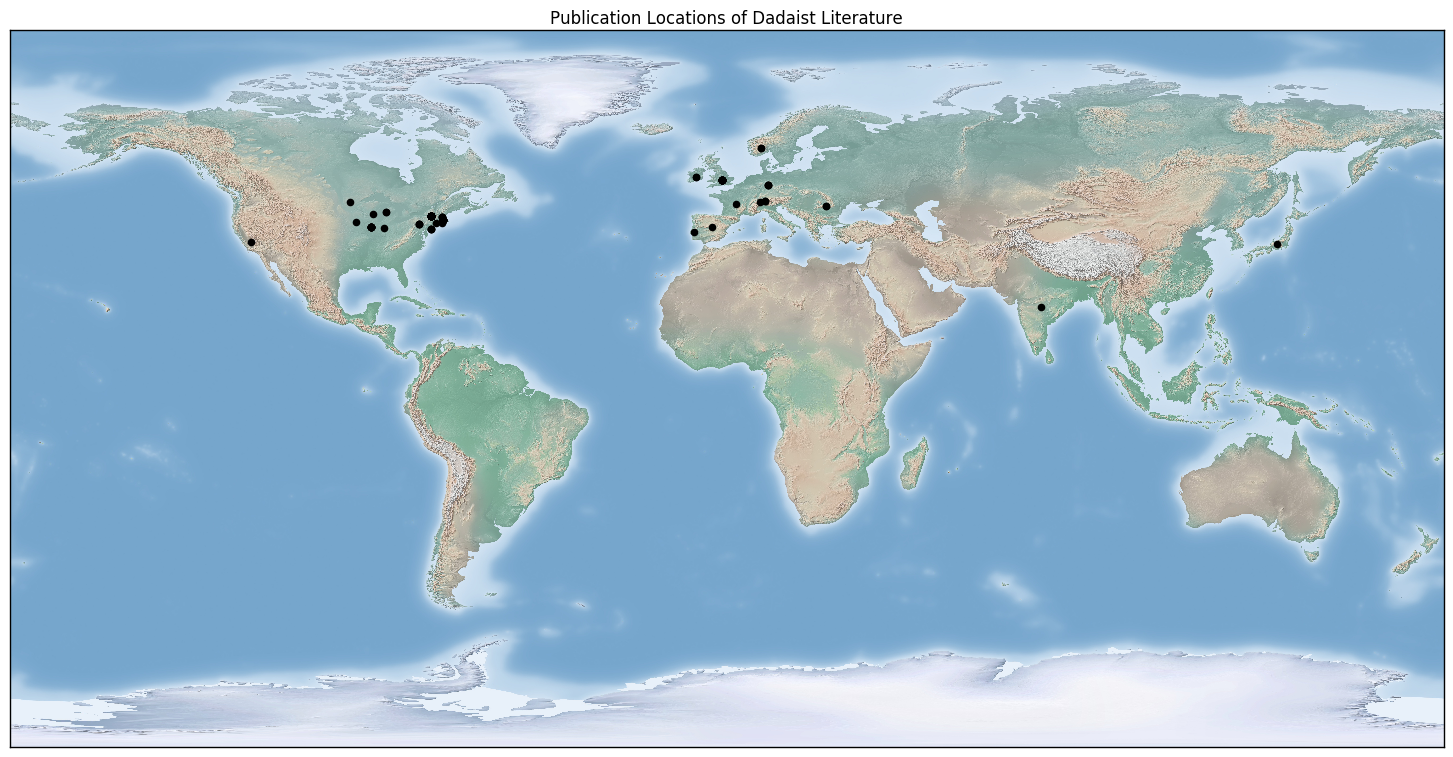

In [158]:
full_map = Basemap(projection='cyl', resolution=None)
full_map.shadedrelief()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

full_map.scatter(new_locations_table["Longitude"], new_locations_table["Latitude"], color="black")
plt.title("Publication Locations of Dadaist Literature")
plt.show()

In [188]:
#Determines whether a location is an American state 
def is_american_state(location):
    return location.endswith("u") == True

In [189]:
place_is_state = np.array([])

#Classifies each location as a US State (True) or not (False)
for abbrv in new_locations_table["Abbreviation"]:
    place_is_state = np.append(place_is_state, is_american_state(abbrv))

In [190]:
new_locations_table["US State?"] = place_is_state

In [191]:
new_locations_table

,Location Name,Abbreviation,Longitude,Latitude,US State?
0,New Hampshire,nhu,-71.572395,43.193852,1.0
1,Iowa,iau,-93.097702,41.878003,1.0
2,New York (State),nyu,-74.217933,43.299428,1.0
3,Illinois,ilu,-89.398528,40.633125,1.0
4,New York (State),nyu,-74.217933,43.299428,1.0
5,New York (State),nyu,-74.217933,43.299428,1.0
6,New York (State),nyu,-74.217933,43.299428,1.0
7,Pennsylvania,pau,-77.194525,41.203322,1.0
8,New York (State),nyu,-74.217933,43.299428,1.0
9,New York (State),nyu,-74.217933,43.299428,1.0


Now, we can examine US states seperately by grouping the locations in our table. Let's start by seeing how much of our data is located in the US.

In [192]:
new_locations_table.groupby("US State?")["Location Name"].count()

US State?
0.0     50
1.0    154
Name: Location Name, dtype: int64

Over 3/4 of our data is located in the US

Let's split our table into 2 parts, one that deals solely with US States, and one that deals with other countries

In [193]:
us_locations = new_locations_table[new_locations_table["US State?"] == True]

In [194]:
rest_locations = new_locations_table[new_locations_table["US State?"] == False]

Let's plot all the US locations in our collection. The tool I use to find boundary latitudes and longitudes for my graphs is [BoundingBox](http://boundingbox.klokantech.com/). Draw a box around the region you want to map, and the boundary coordinates will be at the bottom of the screen. Select "Dublin Core" as the projection, as the coordinates are easier to interpret, and, for our purposes, the projection type won't matter too much. 

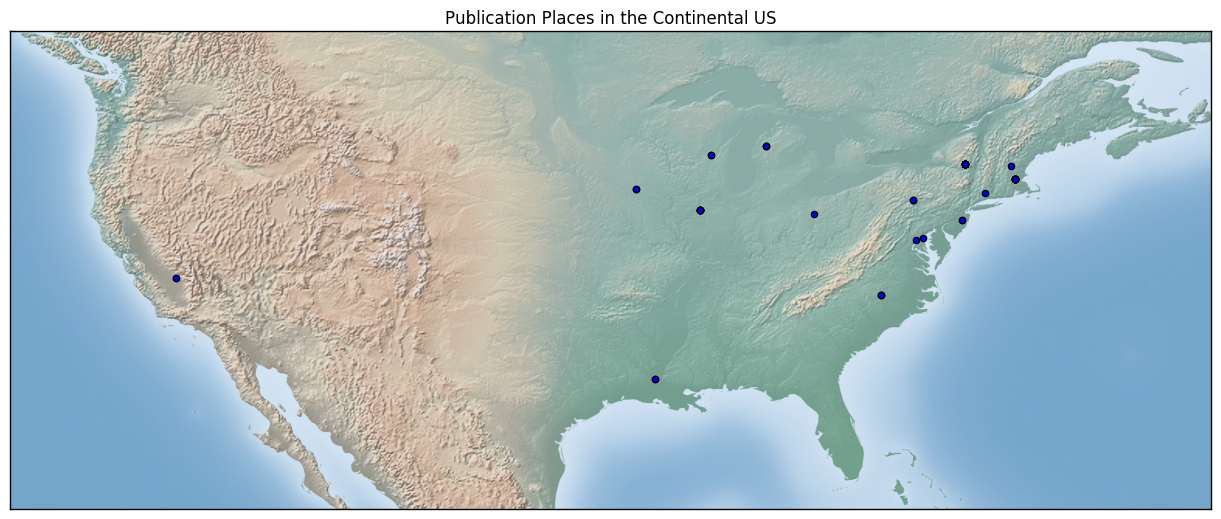

In [200]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt


"‘llcrnr’ stands for ‘lower left corner’ and ‘urcrnr’ stands for upper right corner."
"Fill these in with the latitudes and longitudes that you got earlier."

"westlimit=-128.94; southlimit=23.52; eastlimit=-60.12; northlimit=50.93"

us_locations_map = Basemap(projection='cyl',
            resolution=None, llcrnrlon = -128.94,llcrnrlat =23.52 ,urcrnrlon =-60.12, urcrnrlat =50.93)

us_locations_map.shadedrelief()
#us_locations_map.drawmapboundary(fill_color='aqua')
#us_locations_map.fillcontinents(color='coral',lake_color='aqua')
#us_locations_map.drawcoastlines()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15.5, 12.5)

us_locations_map.scatter(us_locations["Longitude"], us_locations["Latitude"])
plt.title("Publication Places in the Continental US")
plt.show()